In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
import sys
sys.path.append('../')

import skimage
import numpy as np
import util
import eval
from collections import OrderedDict
from matplotlib import pyplot as plt
import sklearn
import scipy
from PIL import Image
import glob
import os
import shutil
import cv2

eval._DEBUG_ = True

/home/jfaath/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


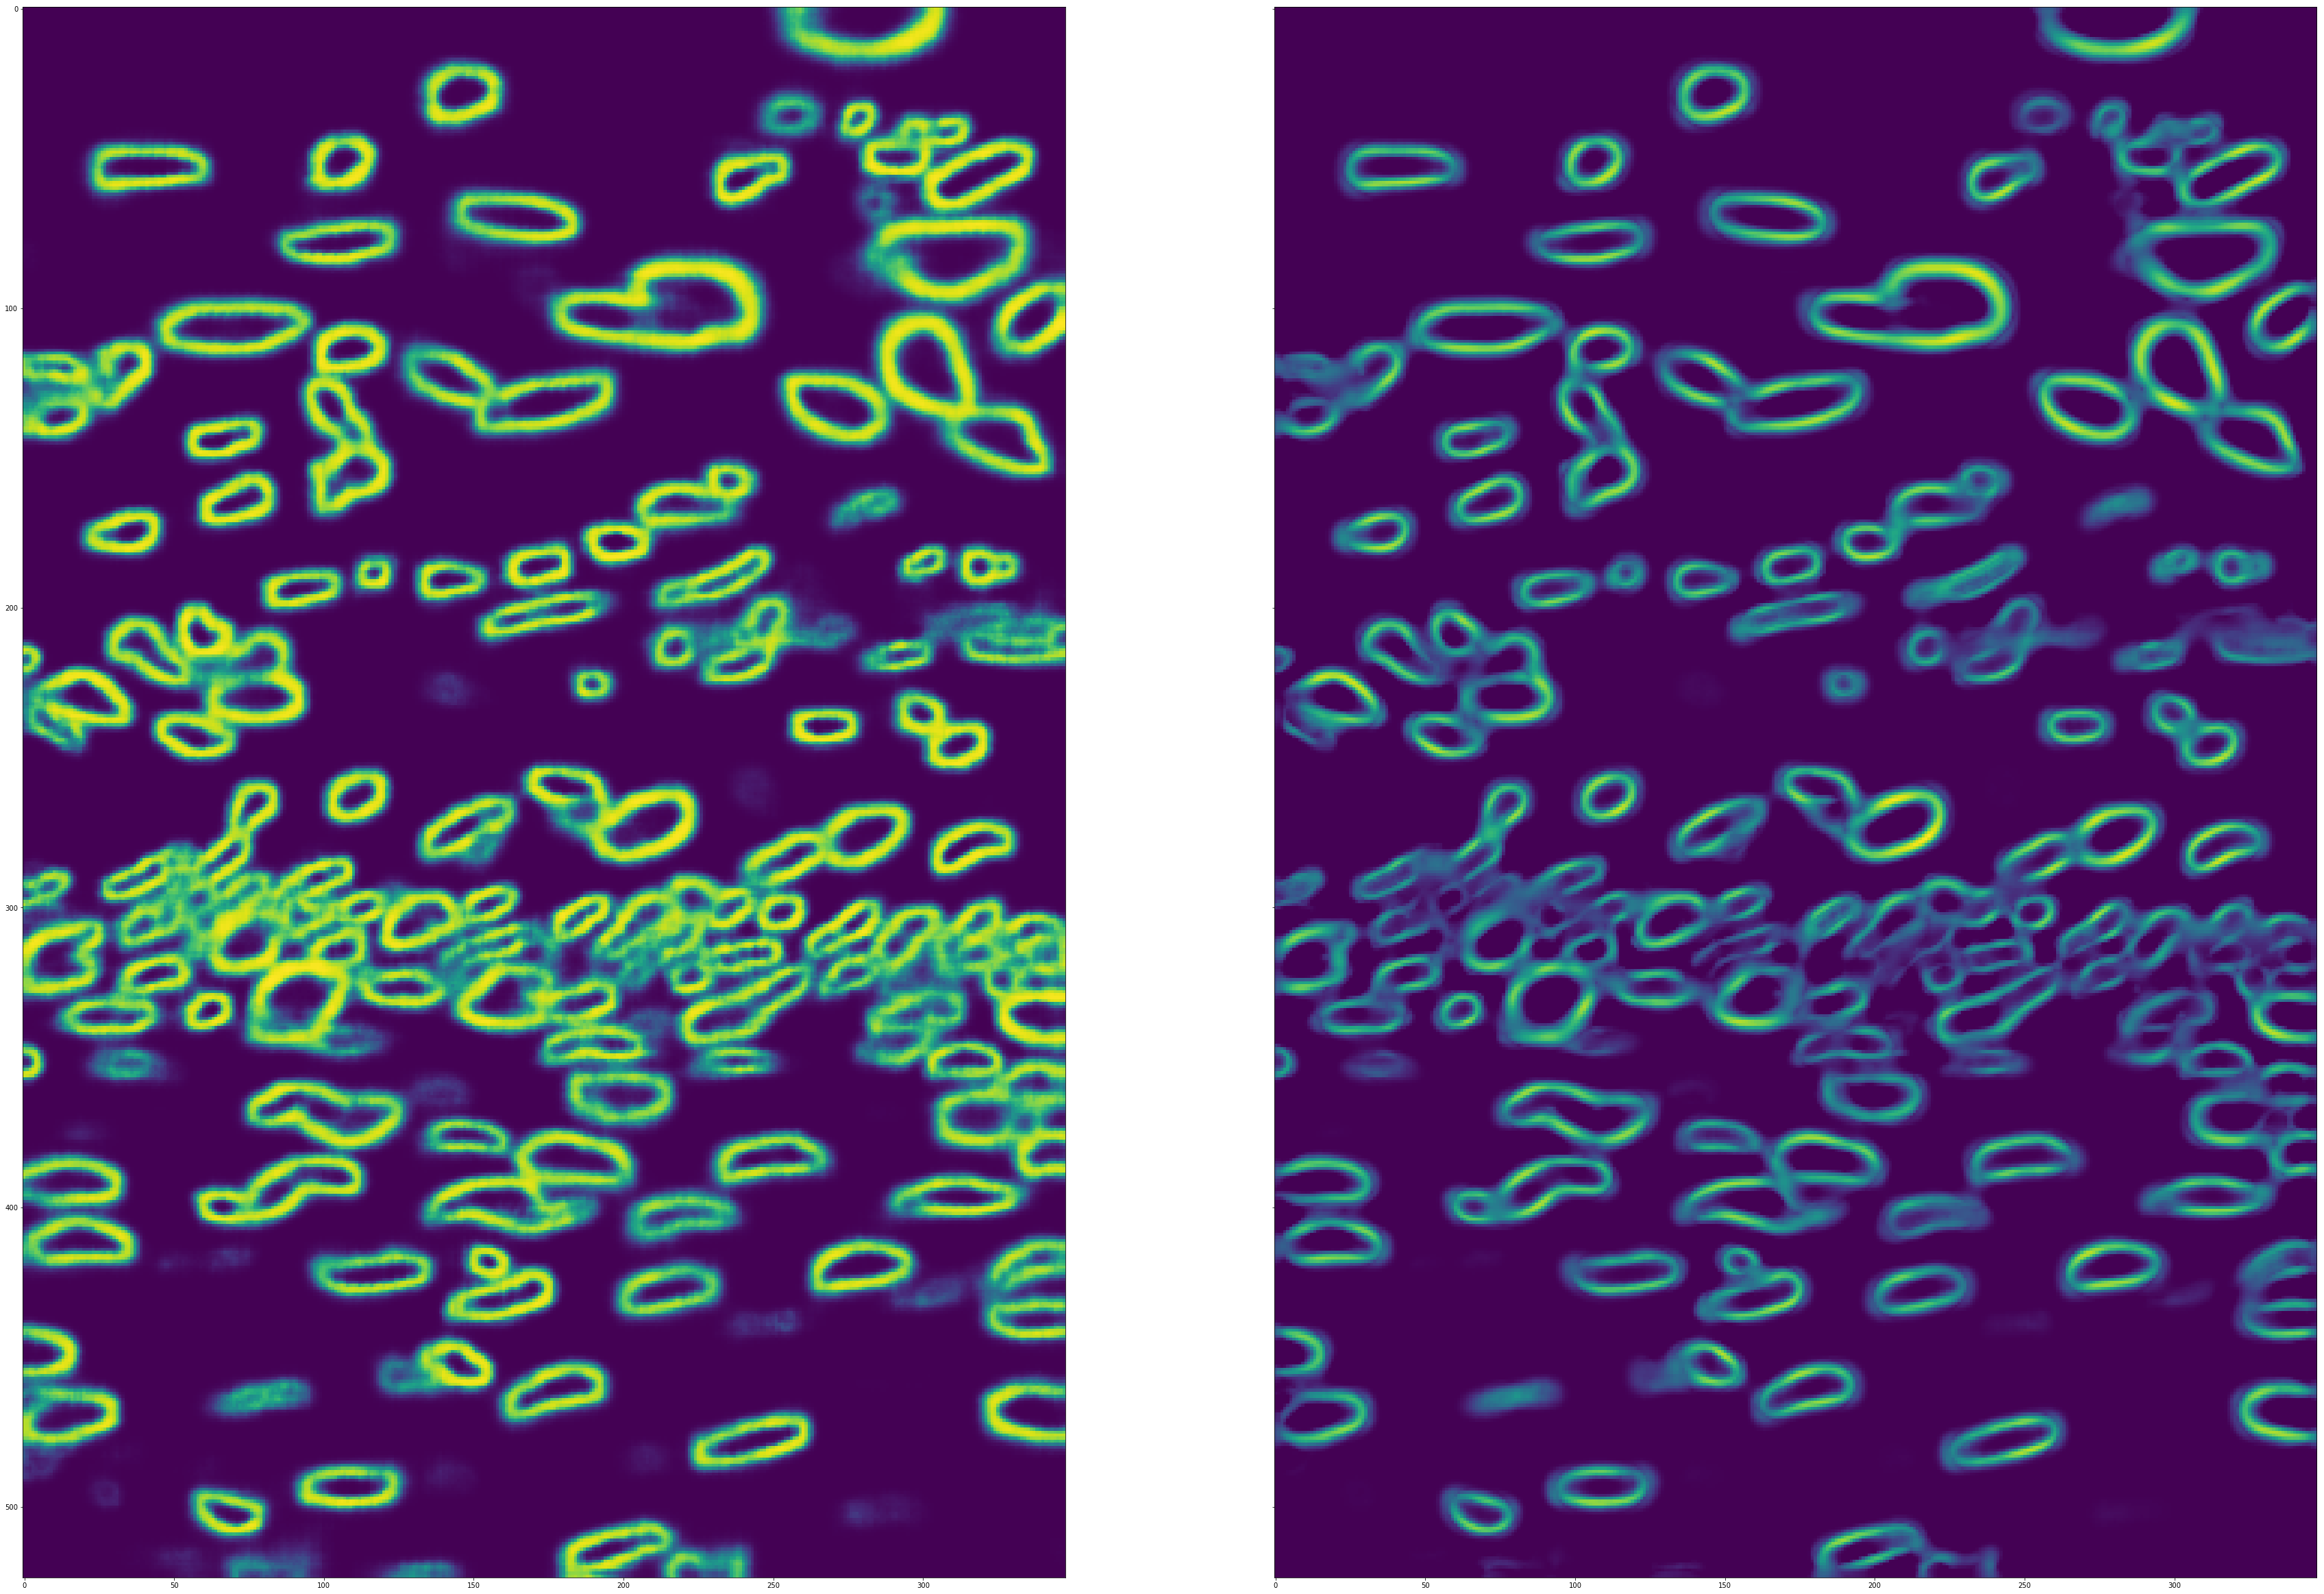

In [3]:
result_con = np.load('/tmp/nuclei/res2.npy')
trans_con = np.load('/tmp/nuclei/con2.npy')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(60, 60), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

ax[0].imshow(result_con)
ax[1].imshow(trans_con)

/home/jfaath/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


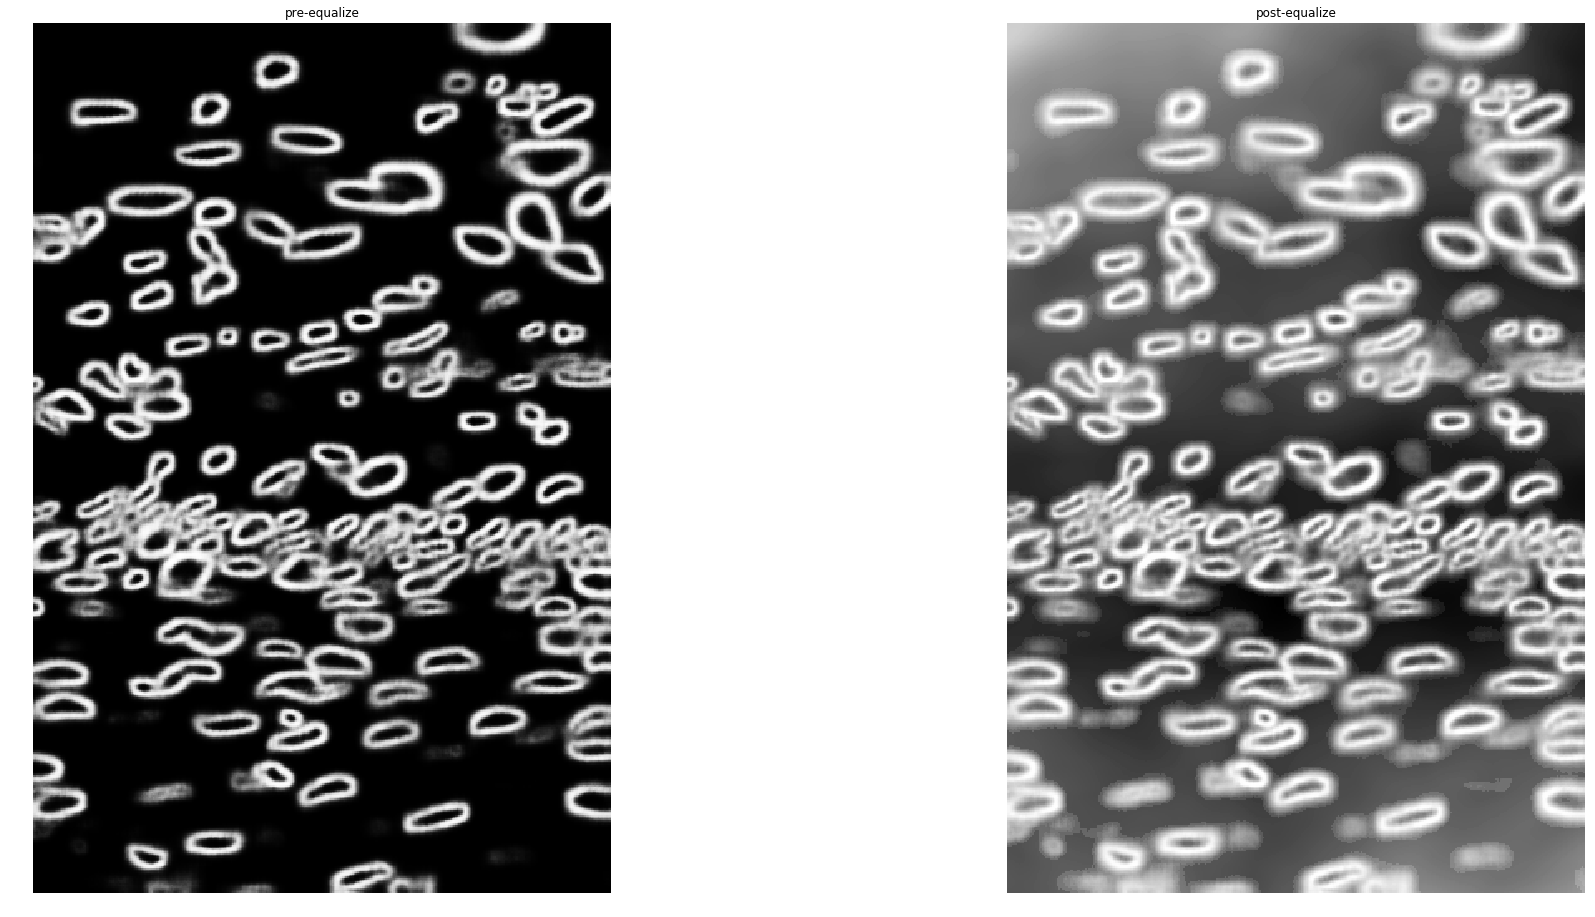

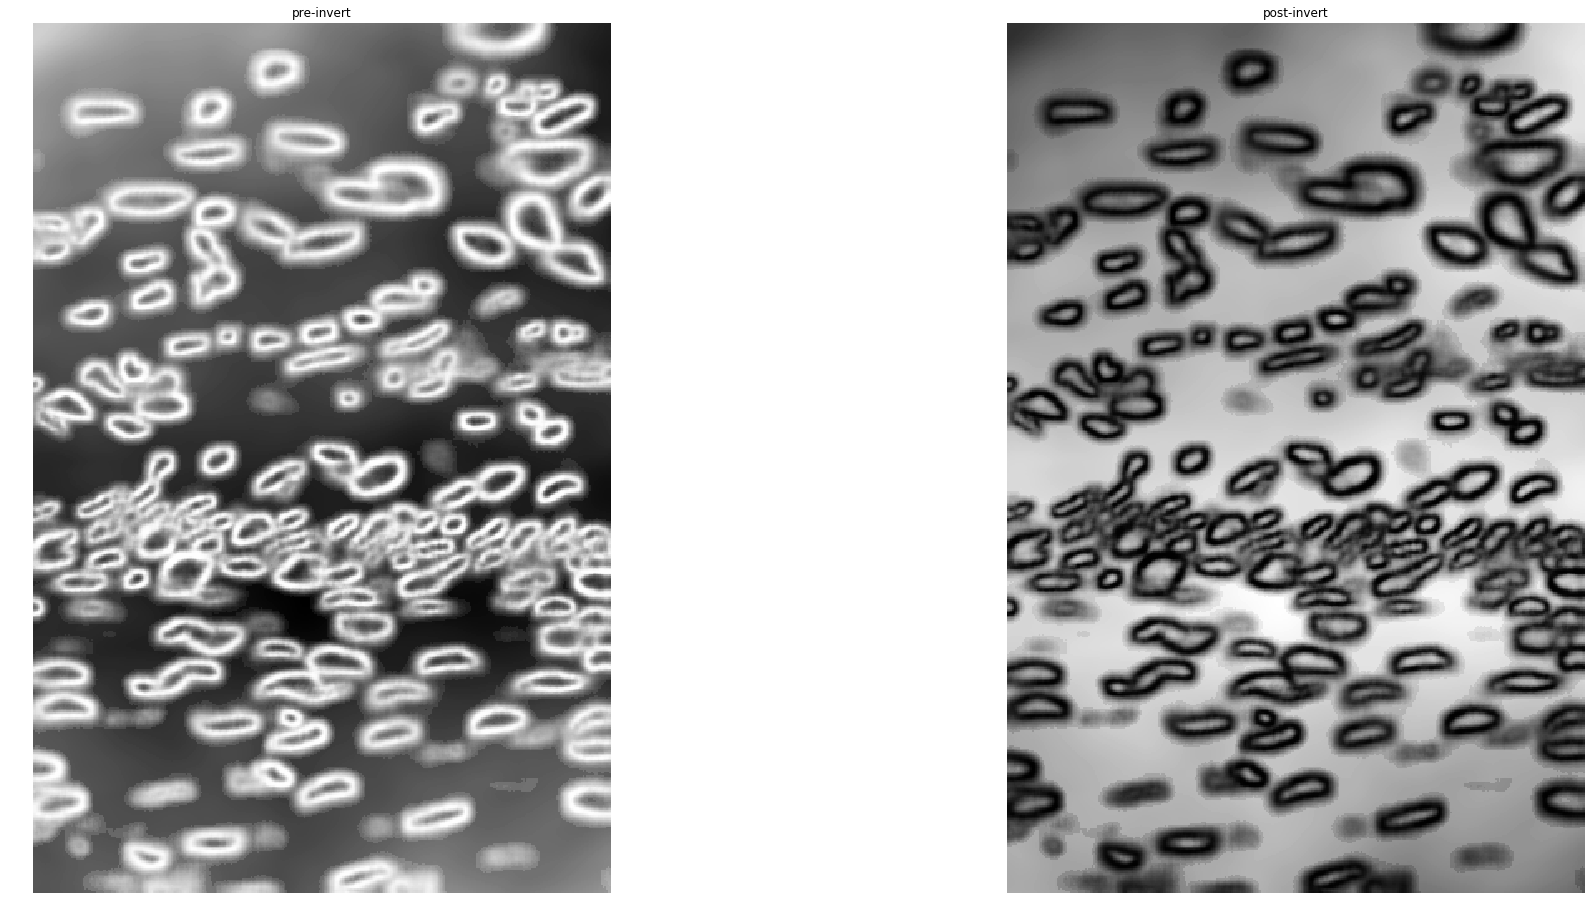

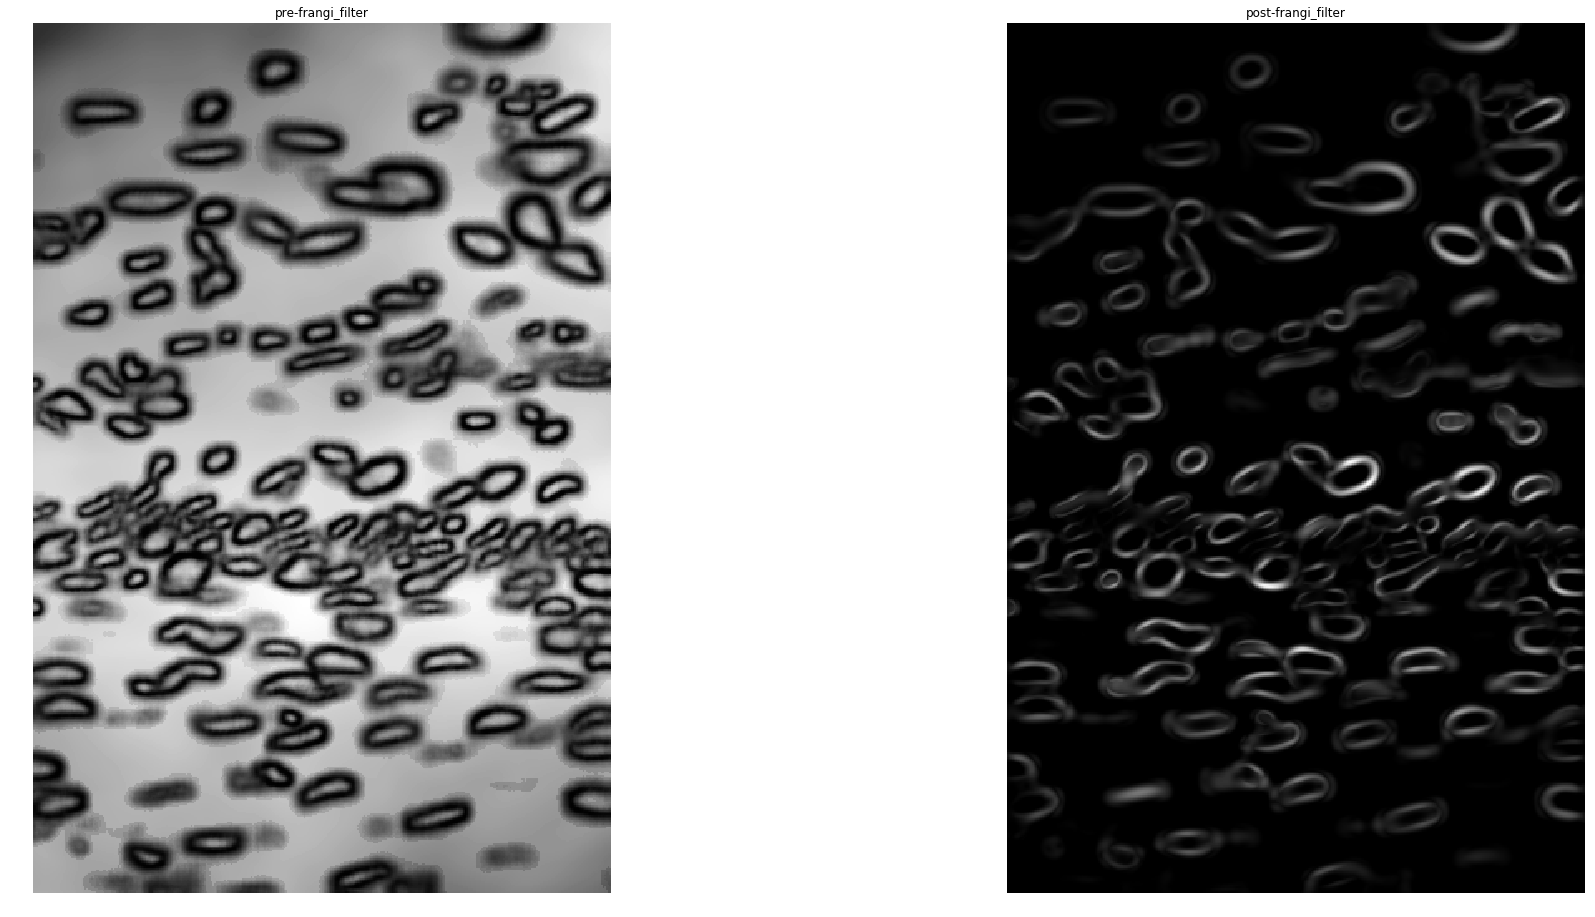

In [99]:
def scale(img):
    return img / np.max(img)

mm = sklearn.preprocessing.MinMaxScaler()

transforms_con = OrderedDict()
#transforms_con[skimage.filters.rank.median] = {'selem': s}
#transforms_con[skimage.filters.laplace] = {}
#transforms_con[mm.fit_transform] = {}
#transforms_con[eval.invert] = {}
#transforms_con[eval.frangi_filter] = {}
#transforms_con[scale] = {}
#transforms_con[skimage.filters.rank.mean_percentile] = {'selem': s, 'p0': 0.1, 'p1': 0.5}
#transforms_con[skimage.exposure.equalize_hist] = {}
#transforms_con[skimage.filters.rank.equalize] = {'selem': s}

s = skimage.morphology.disk(100)
#transforms_con[skimage.filters.rank.mean_bilateral] = {'selem': s, 's0': 0, 's1': 64}
transforms_con[eval.invert] = {}
transforms_con[eval.frangi_filter] = {}
t_con = eval.run_transforms(result_con, transforms_con)
# s = skimage.morphology.disk(10)
# transforms_con[skimage.filters.rank.mean_bilateral] = {'selem': s, 's0': 0, 's1': 64}
# transforms_con[eval.invert] = {}
# transforms_con[scale] = {}
# t_con = eval.run_transforms(t_con, transforms_con)


t_con dtype: float64
t_con max: 0.0001563235439179836
t_con min: 0.0


/home/jfaath/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:314: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


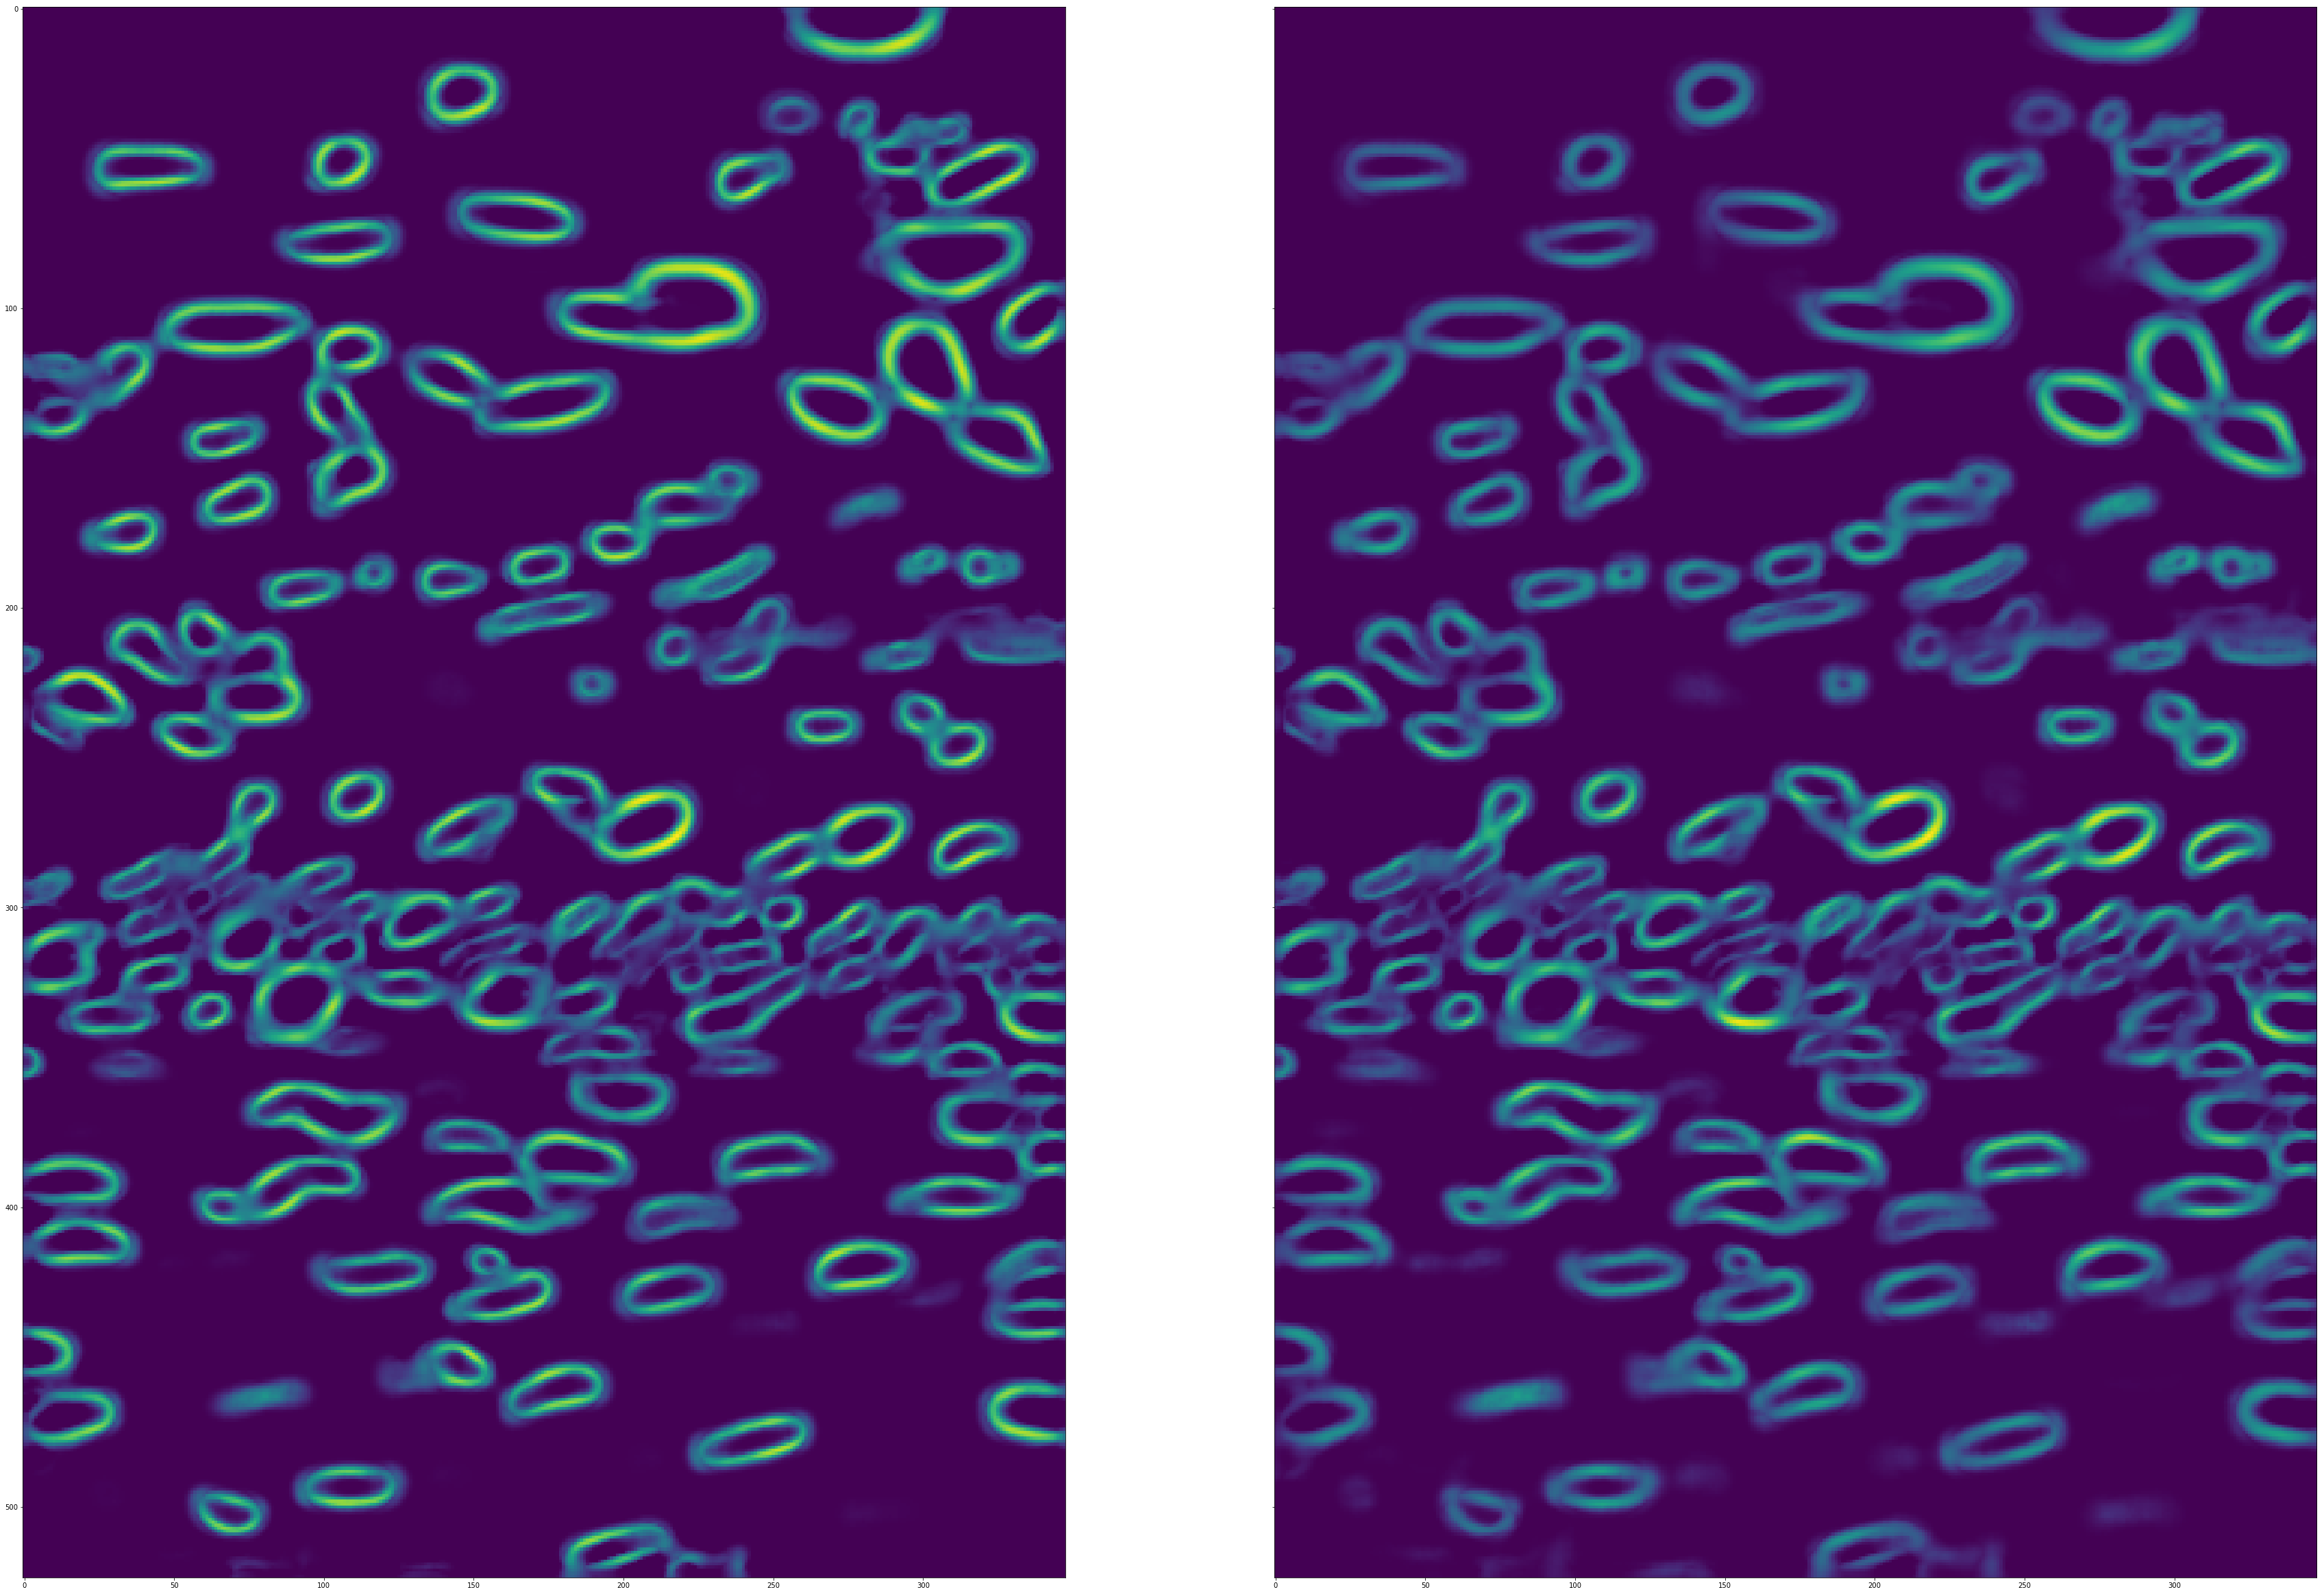

In [100]:
#t_con = t_con / 255.
print(f"t_con dtype: {t_con.dtype}")
print(f"t_con max: {np.max(t_con)}")
print(f"t_con min: {np.min(t_con)}")
trans_con_new = scipy.stats.gmean(np.dstack((result_con, t_con)), axis=2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(60, 60), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

ax[0].imshow(trans_con)
ax[1].imshow(trans_con_new)

(603, 1272)
(603, 1272)
True


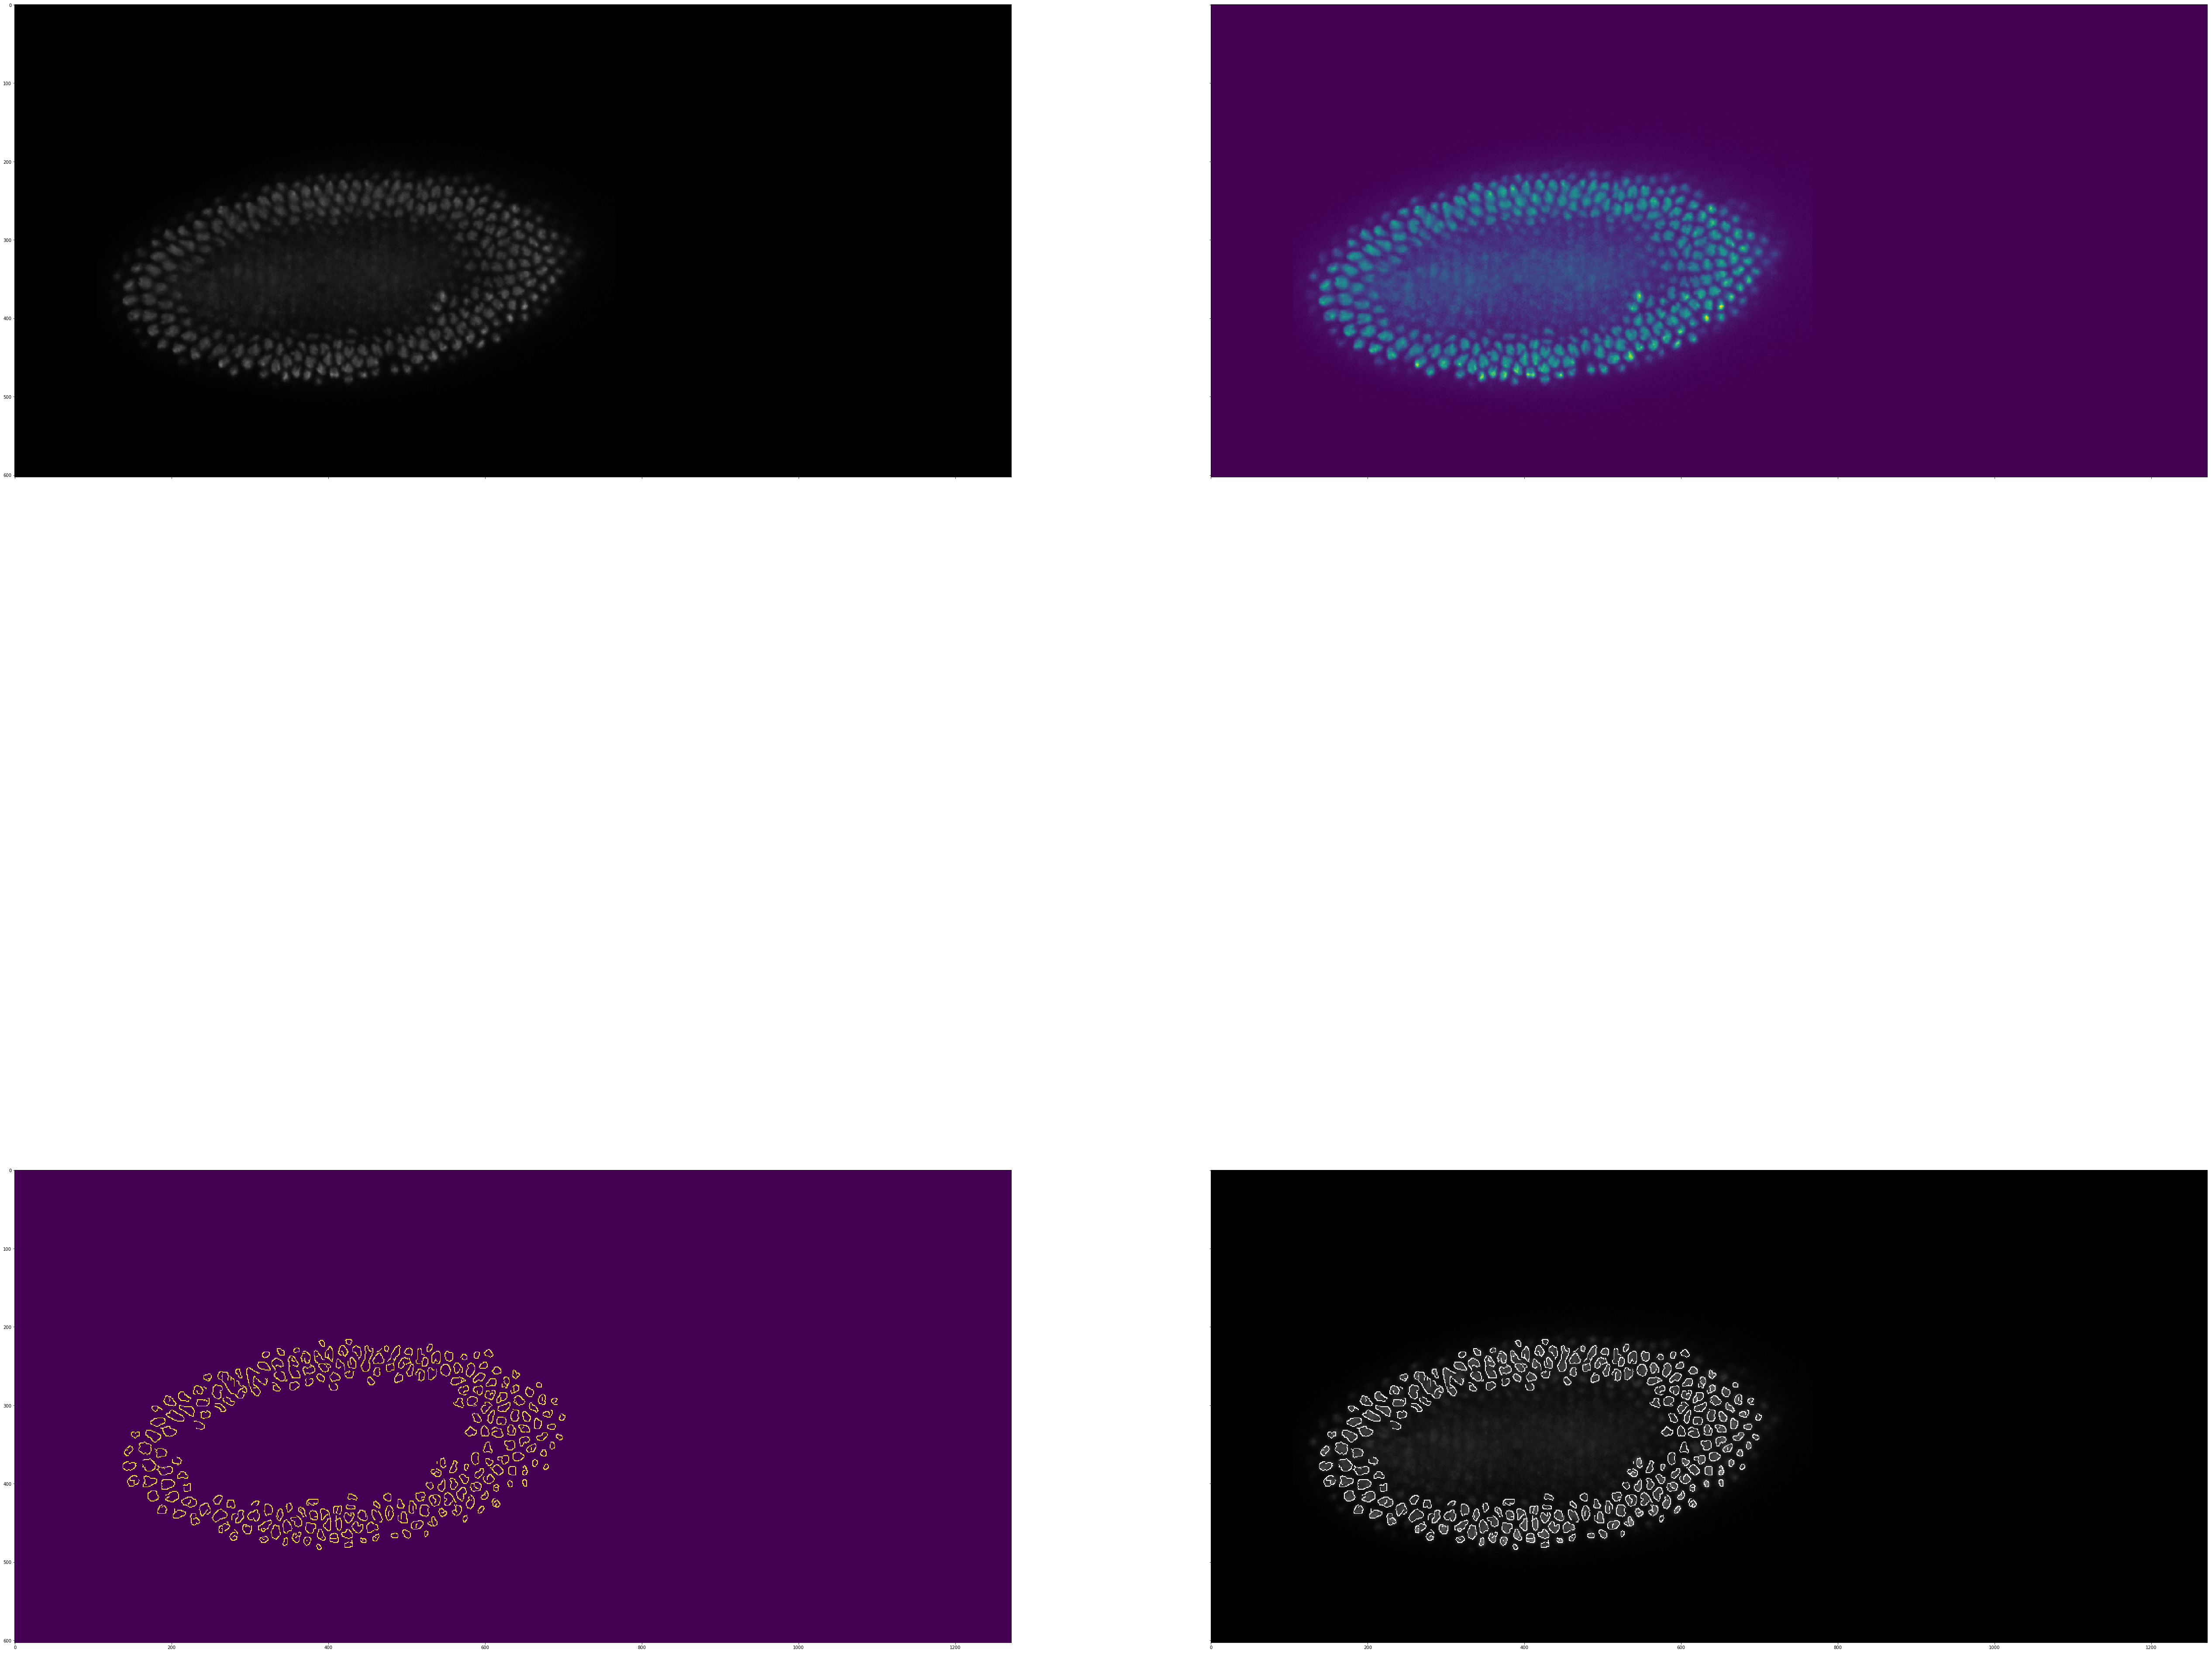

In [46]:
img = Image.open('../model-data/vtest/hold/cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490-src.png')
imga = np.asarray(img)[:,:,0:3]

imgg = img.convert('L')
imgga = np.asarray(imgg)
print(imgga.shape)

imggae = skimage.feature.canny(imgga, sigma=1)
print(imggae.shape)
print(np.max(imggae))

imgam = np.zeros(imga.shape)
imgam[:,:,0] = np.maximum(imga[:,:,0], imggae * 255.)
imgam[:,:,1] = np.maximum(imga[:,:,1], imggae * 255.)
imgam[:,:,2] = np.maximum(imga[:,:,2], imggae * 255.)

imgam = np.asarray(imgam, dtype=np.uint8)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(90, 90), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

ax[0].imshow(img)
ax[1].imshow(imgg)
ax[2].imshow(imggae)
ax[3].imshow(imgam)


Image.fromarray(imgam).save('../model-data/test.png')

In [4]:
def convert_masks(image_id, combine_threshold=0.20):
    nm = str(int(combine_threshold * 100))
    
    os.makedirs(f"../raw-data/train-newf{nm}/{image_id}/images", exist_ok=True)
    os.makedirs(f"../raw-data/train-newf{nm}/{image_id}/masks", exist_ok=True)
    img_src = f"../raw-data/train-new/{image_id}/images/{image_id}.png"
    shutil.copy2(img_src, img_src.replace('train-new', f"train-newf{nm}"))

    combined_masks = set()

    search_path = f"../raw-data/train-new/{image_id}/masks/*.png"
    mask_files = glob.glob(search_path)
    for i in range(len(mask_files)):
        if mask_files[i] in combined_masks:
            continue

        working_mask = np.asarray(Image.open(mask_files[i])) / 255.
        for j in range(i+1, len(mask_files)):
            if mask_files[j] in combined_masks:
                continue

            compare_mask = np.asarray(Image.open(mask_files[j])) / 255.
            area = np.sum(compare_mask)

            intersection = np.logical_and(working_mask, compare_mask)
            area_intersection = np.sum(intersection)

            overlap = area_intersection / area
            if overlap > combine_threshold:            
                working_mask = np.logical_or(working_mask, compare_mask)
                combined_masks.add(mask_files[j])
            else:
                working_mask = np.logical_xor(working_mask, intersection)

        Image.fromarray(skimage.img_as_ubyte(working_mask)).save(mask_files[i].replace('train-new', f"train-newf{nm}"))
        

In [5]:
from multiprocessing import Pool

def list_convert_masks(image_ids):
    for image_id in image_ids:
        print(f"On image id: {image_id}")
        convert_masks(image_id)

image_ids = []
search_path = '../raw-data/train-new/*'
for file in glob.glob(search_path):
    if os.path.isdir(file):
        image_id = os.path.basename(file)
        image_ids.append(image_id)

pool = Pool(processes=8)
pool.map(list_convert_masks, (image_ids[0:4],
                              image_ids[4:8],
                              image_ids[8:12],
                              image_ids[12:16],
                              image_ids[16:20],
                              image_ids[20:24],
                              image_ids[24:27],
                              image_ids[27:30]))

# Affected by overwriting:
# On image id: TCGA-E2-A1B5-01Z-00-DX1
# On image id: TCGA-NH-A8F7-01A-01-TS1
# On image id: TCGA-AY-A8YK-01A-01-TS1
# On image id: TCGA-RD-A8N9-01A-01-TS1
# On image id: TCGA-HE-7129-01Z-00-DX1
# On image id: TCGA-B0-5711-01Z-00-DX1
# On image id: TCGA-G9-6336-01Z-00-DX1
# On image id: TCGA-18-5592-01Z-00-DX1

On image id: TCGA-E2-A1B5-01Z-00-DX1
On image id: TCGA-RD-A8N9-01A-01-TS1
On image id: TCGA-HE-7129-01Z-00-DX1
On image id: TCGA-B0-5711-01Z-00-DX1
On image id: TCGA-AY-A8YK-01A-01-TS1
On image id: TCGA-G9-6336-01Z-00-DX1
On image id: TCGA-18-5592-01Z-00-DX1
On image id: TCGA-NH-A8F7-01A-01-TS1


/home/jfaath/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


On image id: TCGA-38-6178-01Z-00-DX1


/home/jfaath/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


On image id: TCGA-DK-A2I6-01A-01-TS1


/home/jfaath/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


On image id: TCGA-50-5931-01Z-00-DX1


/home/jfaath/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


On image id: TCGA-A7-A13E-01Z-00-DX1


/home/jfaath/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


On image id: TCGA-G9-6362-01Z-00-DX1
On image id: TCGA-B0-5710-01Z-00-DX1


/home/jfaath/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


On image id: TCGA-G2-A2EK-01A-02-TSB
On image id: TCGA-G9-6363-01Z-00-DX1
On image id: TCGA-49-4488-01Z-00-DX1
On image id: TCGA-CH-5767-01Z-00-DX1
On image id: TCGA-G9-6348-01Z-00-DX1
On image id: TCGA-21-5784-01Z-00-DX1
On image id: TCGA-A7-A13F-01Z-00-DX1
On image id: TCGA-E2-A14V-01Z-00-DX1
On image id: TCGA-HE-7130-01Z-00-DX1
On image id: TCGA-G9-6356-01Z-00-DX1


/home/jfaath/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


On image id: TCGA-HE-7128-01Z-00-DX1


/home/jfaath/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


On image id: TCGA-AR-A1AK-01Z-00-DX1
On image id: TCGA-21-5786-01Z-00-DX1
On image id: TCGA-B0-5698-01Z-00-DX1
On image id: TCGA-KB-A93J-01A-01-TS1
On image id: TCGA-AR-A1AS-01Z-00-DX1


[None, None, None, None, None, None, None, None]

(100, 100, 3)
[[  0  14   3 456]]
[1.78125, 4.296875, 0.4453125, 0.4453125, 5.73046875]


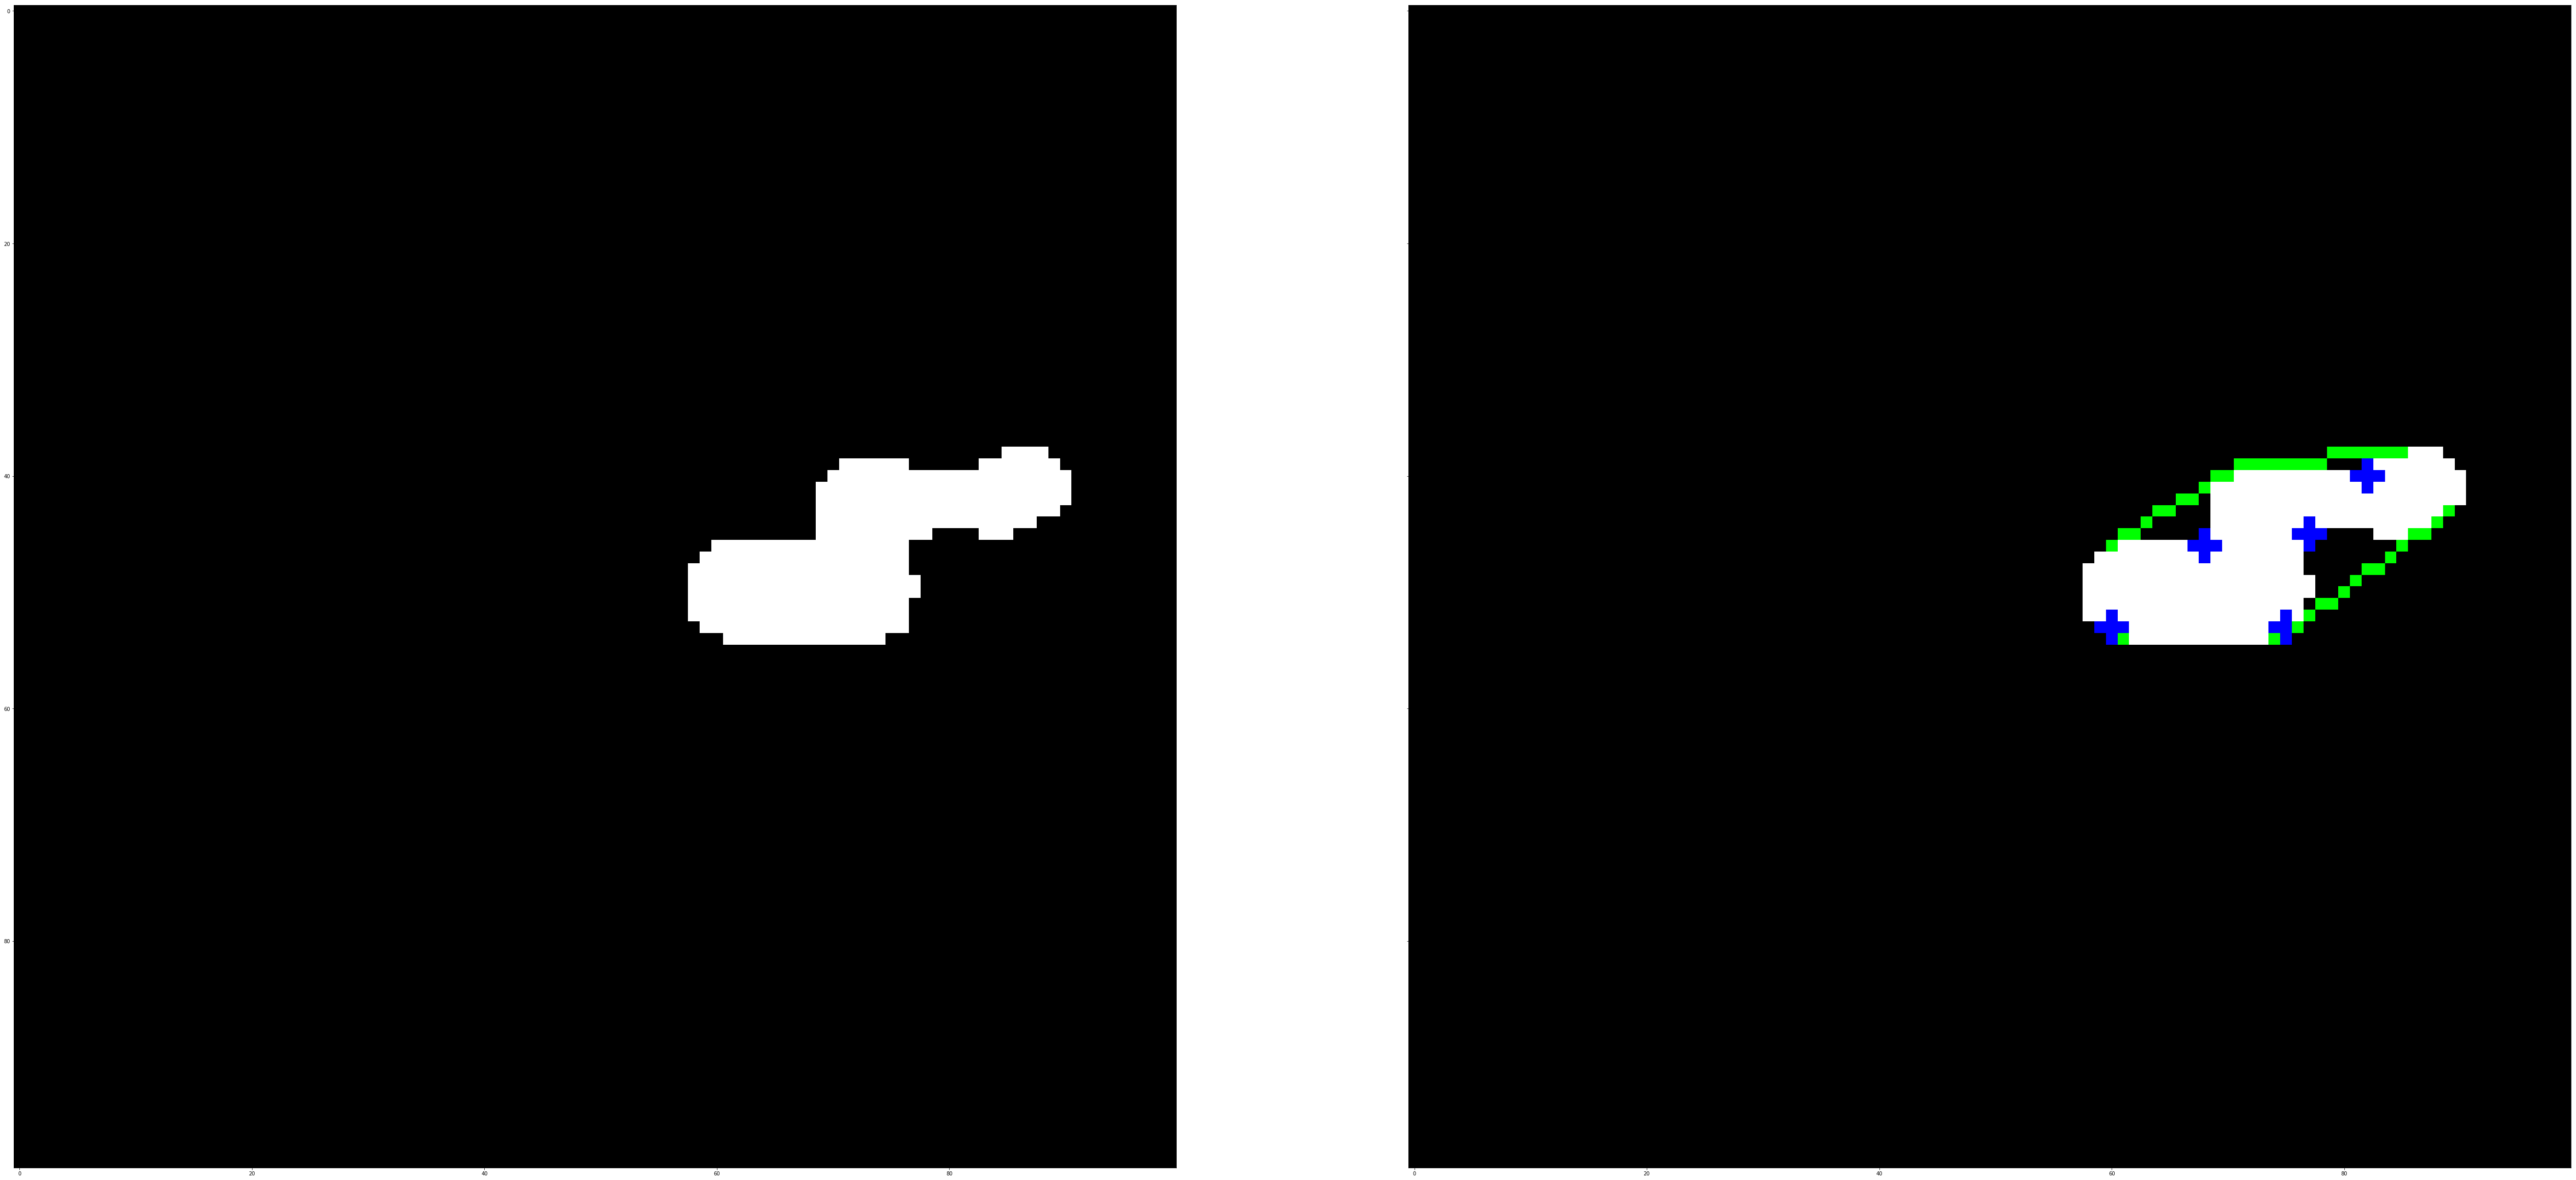

In [20]:
#img = cv2.imread('star.jpg')
#img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#ret, thresh = cv2.threshold(img_gray, 127, 255,0)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(90, 90), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

labels = np.load('/tmp/nuclei/bs20_51init_03/3c4c675825f7509877bc10497f498c9a2e3433bf922bd870914a2eb21a54fd26.npy')
rprops = skimage.measure.regionprops(labels)

for i in range(1, labels.max() + 1):
    if rprops[i - 1].convex_area / rprops[i - 1].filled_area > 1.1:
        mask = (labels == i).astype(np.uint8)
        img = np.copy(mask) * 255
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        
        mask = mask[0:100,224:324]
        img = img[0:100,224:324]
        print(img.shape)
        
        ax[0].imshow(img)
        
        _, contours, _ = cv2.findContours(mask, 2, 1)
        cnt = contours[0]
        #print(cnt.shape)

        hull = cv2.convexHull(cnt, returnPoints = False)
        #print(hull)
        #ax[1].imshow(hull)

        defects = cv2.convexityDefects(cnt, hull)
        dpt_dists = [d[0,3] / 256. for d in defects]
        print(dpt_dists)
        print(dpt)
        
        for i in range(defects.shape[0]):
            s,e,f,d = defects[i,0]
            start = tuple(cnt[s][0])
            end = tuple(cnt[e][0])
            far = tuple(cnt[f][0])
            dist_n = d / 256.
            
            
            cv2.line(img,start,end,[0,255,0],1)
            cv2.circle(img,far,1,[0,0,255],-1)
    
        ax[1].imshow(img)
        
        
        break